In [3]:
import pandas as pd
import numpy as np
#custom script to merge entries
import matplotlib.pyplot as plt
from pathlib import Path  
from utils import filter_by_column_value, plot_range_pie, count_nulls, count_nulls_debug, filter_by_column_value_over_under
from geopy.distance import geodesic

## Goals of this notebook
Enrich the dataset with the stations metadata.
In this case we'll be adding two new features - stations size, and distances between stations, derived from their coordinates
<b>Note</b>
When calculating distances between stations, we'll be calculating shortest possible path between stations on earth (like a straight line). Real train routes will have a different distance, however I assume that the variations between actual and shortest distance will be minimal.



In [4]:
main_dataset = pd.read_csv('preprocessed_data/preprocessed_time_features_added.csv')

In [ ]:
stations_nl = pd.read_csv('preprocessed_data/stations_clean_v2.csv')

In [6]:
main_dataset.head()

,Journey id,Train type,Departure station code,Arrival station code,Departure station name,Arrival station name,Departure time,Arrival time,Departure delay,Arrival delay,Part number,Cancelled,Departure platform changed,Arrival platform changed,Is_weekend,Is_holiday,Is rush hour
0,12690865,Intercity,RTD,DT,Rotterdam Centraal,Delft,2024-01-01T02:00:00+01:00,2024-01-01T02:13:00+01:00,0.0,0.0,1,False,False,False,False,True,False
1,12690865,Intercity,DT,GV,Delft,Den Haag HS,2024-01-01T02:13:00+01:00,2024-01-01T02:21:00+01:00,0.0,0.0,2,False,False,False,False,True,False
2,12690865,Intercity,GV,LEDN,Den Haag HS,Leiden Centraal,2024-01-01T02:22:00+01:00,2024-01-01T02:35:00+01:00,0.0,0.0,3,False,False,True,False,True,False
3,12690865,Intercity,LEDN,SHL,Leiden Centraal,Schiphol Airport,2024-01-01T02:40:00+01:00,2024-01-01T03:00:00+01:00,0.0,0.0,4,False,True,False,False,True,False
4,12690865,Intercity,SHL,ASS,Schiphol Airport,Amsterdam Sloterdijk,2024-01-01T03:03:00+01:00,2024-01-01T03:12:00+01:00,0.0,0.0,5,False,False,False,False,True,False


In [7]:
mask = main_dataset['Arrival station code'].isin(stations_nl['code'])
unique_count = main_dataset.loc[mask, 'Arrival station code'].nunique()  # fast

In [8]:
print(unique_count)

262


In [9]:
#conclusion: even though there are 397 train stations, we are only working with 257 of them.
#Some one-hot encodings will be excluded then.

In [10]:
unique_station_types = stations_nl['type'].unique()

In [11]:
print(unique_station_types)

['knooppuntIntercitystation' 'stoptreinstation' 'intercitystation'
 'knooppuntStoptreinstation' 'megastation' 'knooppuntSneltreinstation'
 'sneltreinstation' 'facultatiefStation']


In [12]:
main_dataset = (
    main_dataset
        .merge(
            stations_nl[['code', 'type', 'geo_lat', 'geo_lng', 'Nr trains 2024']],
            left_on='Departure station code',
            right_on='code',
            how='left'
        )
        .rename(columns={
            'type': 'Departure station type',
            'geo_lat': 'Dep geo lat',
            'geo_lng': 'Dep geo lng',
            'Nr trains 2024': 'Dep Trains 2024'
        })
        .drop(columns='code')  # remove duplicate join key
)


KeyError: "['Nr trains 2024'] not in index"

In [ ]:
main_dataset = (
    main_dataset
        .merge(
            stations_nl[['code', 'type', 'geo_lat', 'geo_lng', 'Nr trains 2024']],
            left_on='Arrival station code',
            right_on='code',
            how='left'
        )
        .rename(columns={
            'type': 'Arrival station type',
            'geo_lat': 'Arr geo lat',
            'geo_lng': 'Arr geo lng',
            'Nr trains 2024': 'Arr Trains 2024'
        })
        .drop(columns='code')  # remove duplicate join key
)


In [ ]:
main_dataset.head()

,Journey id,Train type,Departure station code,Arrival station code,Departure station name,Arrival station name,Departure time,Arrival time,Departure delay,Arrival delay,...,Arrival platform changed,Is_weekend,Is_holiday,Is rush hour,Departure station type,Dep geo lat,Dep geo lng,Arrival station type,Arr geo lat,Arr geo lng
0,12690865,Intercity,RTD,DT,Rotterdam Centraal,Delft,2024-01-01T02:00:00+01:00,2024-01-01T02:13:00+01:00,0.0,0.0,...,False,False,True,False,megastation,51.924999,4.468889,knooppuntIntercitystation,52.006668,4.356389
1,12690865,Intercity,DT,GV,Delft,Den Haag HS,2024-01-01T02:13:00+01:00,2024-01-01T02:21:00+01:00,0.0,0.0,...,False,False,True,False,knooppuntIntercitystation,52.006668,4.356389,knooppuntIntercitystation,52.069721,4.322500
2,12690865,Intercity,GV,LEDN,Den Haag HS,Leiden Centraal,2024-01-01T02:22:00+01:00,2024-01-01T02:35:00+01:00,0.0,0.0,...,True,False,True,False,knooppuntIntercitystation,52.069721,4.322500,knooppuntIntercitystation,52.166111,4.481667
3,12690865,Intercity,LEDN,SHL,Leiden Centraal,Schiphol Airport,2024-01-01T02:40:00+01:00,2024-01-01T03:00:00+01:00,0.0,0.0,...,False,False,True,False,knooppuntIntercitystation,52.166111,4.481667,megastation,52.309444,4.761944
4,12690865,Intercity,SHL,ASS,Schiphol Airport,Amsterdam Sloterdijk,2024-01-01T03:03:00+01:00,2024-01-01T03:12:00+01:00,0.0,0.0,...,False,False,True,False,megastation,52.309444,4.761944,knooppuntIntercitystation,52.388889,4.837778


In [ ]:
unique_station_types = stations_nl['type'].unique()

for item in unique_station_types:
    boolean_list = []
    for station in main_dataset["Departure station type"]:
        if station == item:
            boolean_list.append(True)
        else:
            boolean_list.append(False)
    res = all(not i for i in boolean_list)
    if not res:
        main_dataset[f"Dep {item}"] = boolean_list

for item in unique_station_types:
    boolean_list = []
    for station in main_dataset["Arrival station type"]:
        if station == item:
            boolean_list.append(True)
        else:
            boolean_list.append(False)
    res = all(not i for i in boolean_list)
    if not res:
        main_dataset[f"Arr {item}"] = boolean_list

In [ ]:
len(main_dataset)

12301706

In [ ]:
main_dataset.head()

,Journey id,Train type,Departure station code,Arrival station code,Departure station name,Arrival station name,Departure time,Arrival time,Departure delay,Arrival delay,...,Dep knooppuntStoptreinstation,Dep megastation,Dep knooppuntSneltreinstation,Dep facultatiefStation,Arr knooppuntIntercitystation,Arr stoptreinstation,Arr intercitystation,Arr knooppuntStoptreinstation,Arr megastation,Arr facultatiefStation
0,12690865,Intercity,RTD,DT,Rotterdam Centraal,Delft,2024-01-01T02:00:00+01:00,2024-01-01T02:13:00+01:00,0.0,0.0,...,False,True,False,False,True,False,False,False,False,False
1,12690865,Intercity,DT,GV,Delft,Den Haag HS,2024-01-01T02:13:00+01:00,2024-01-01T02:21:00+01:00,0.0,0.0,...,False,False,False,False,True,False,False,False,False,False
2,12690865,Intercity,GV,LEDN,Den Haag HS,Leiden Centraal,2024-01-01T02:22:00+01:00,2024-01-01T02:35:00+01:00,0.0,0.0,...,False,False,False,False,True,False,False,False,False,False
3,12690865,Intercity,LEDN,SHL,Leiden Centraal,Schiphol Airport,2024-01-01T02:40:00+01:00,2024-01-01T03:00:00+01:00,0.0,0.0,...,False,False,False,False,False,False,False,False,True,False
4,12690865,Intercity,SHL,ASS,Schiphol Airport,Amsterdam Sloterdijk,2024-01-01T03:03:00+01:00,2024-01-01T03:12:00+01:00,0.0,0.0,...,False,True,False,False,True,False,False,False,False,False


In [ ]:
filtered = filter_by_column_value(main_dataset, "Dep intercitystation", True)

In [ ]:
filtered.head()

,Journey id,Train type,Departure station code,Arrival station code,Departure station name,Arrival station name,Departure time,Arrival time,Departure delay,Arrival delay,...,Dep knooppuntStoptreinstation,Dep megastation,Dep knooppuntSneltreinstation,Dep facultatiefStation,Arr knooppuntIntercitystation,Arr stoptreinstation,Arr intercitystation,Arr knooppuntStoptreinstation,Arr megastation,Arr facultatiefStation
67,12690879,Sprinter,ASDZ,SHL,Amsterdam Zuid,Schiphol Airport,2024-01-01T05:37:00+01:00,2024-01-01T05:43:00+01:00,5.0,5.0,...,False,False,False,False,False,False,False,False,True,False
91,12690883,Sprinter,CAS,UTG,Castricum,Uitgeest,2024-01-01T05:12:00+01:00,2024-01-01T05:16:00+01:00,0.0,1.0,...,False,False,False,False,False,False,False,True,False,False
154,12690963,Intercity,ASA,ASB,Amsterdam Amstel,Amsterdam Bijlmer ArenA,2024-01-01T09:01:00+01:00,2024-01-01T09:06:00+01:00,0.0,1.0,...,False,False,False,False,False,False,False,True,False,False
171,12691010,Intercity,ASA,ASB,Amsterdam Amstel,Amsterdam Bijlmer ArenA,2024-01-01T09:31:00+01:00,2024-01-01T09:36:00+01:00,1.0,1.0,...,False,False,False,False,False,False,False,True,False,False
189,12691092,Intercity,ASA,ASD,Amsterdam Amstel,Amsterdam Centraal,2024-01-01T09:02:00+01:00,2024-01-01T09:10:00+01:00,0.0,0.0,...,False,False,False,False,False,False,False,False,True,False


In [ ]:
test_ranges_1 = [(0,0), (1, 2), (3, 5), (6, 10), (11, 20), (21, 40), (41, 180), (180, 1001)]

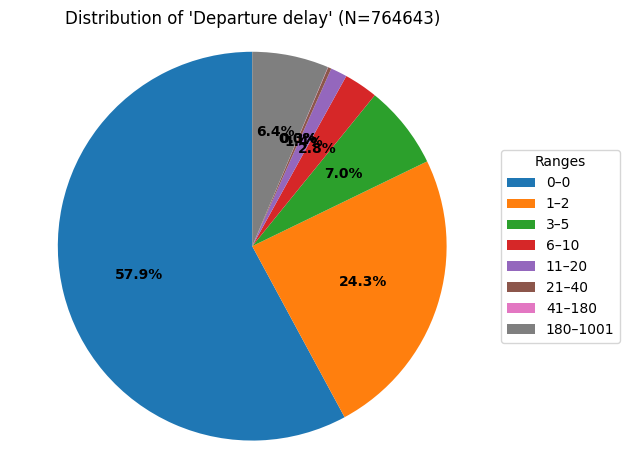

0–0 - 57.9%, 442592
1–2 - 24.3%, 185820
3–5 - 7.0%, 53225
6–10 - 2.8%, 21530
11–20 - 1.4%, 10495
21–40 - 0.3%, 2136
41–180 - 0.0%, 172
180–1001 - 6.4%, 48672


['0–0 - 57.9%, 442592',
 '1–2 - 24.3%, 185820',
 '3–5 - 7.0%, 53225',
 '6–10 - 2.8%, 21530',
 '11–20 - 1.4%, 10495',
 '21–40 - 0.3%, 2136',
 '41–180 - 0.0%, 172',
 '180–1001 - 6.4%, 48672']

In [ ]:
plot_range_pie(filtered, "Departure delay", test_ranges_1)

In [ ]:
main_dataset = main_dataset.drop(['Arrival station type', 'Departure station type'], axis = 1)

In [ ]:
main_dataset.head()

,Journey id,Train type,Departure station code,Arrival station code,Departure station name,Arrival station name,Departure time,Arrival time,Departure delay,Arrival delay,...,Dep knooppuntStoptreinstation,Dep megastation,Dep knooppuntSneltreinstation,Dep facultatiefStation,Arr knooppuntIntercitystation,Arr stoptreinstation,Arr intercitystation,Arr knooppuntStoptreinstation,Arr megastation,Arr facultatiefStation
0,12690865,Intercity,RTD,DT,Rotterdam Centraal,Delft,2024-01-01T02:00:00+01:00,2024-01-01T02:13:00+01:00,0.0,0.0,...,False,True,False,False,True,False,False,False,False,False
1,12690865,Intercity,DT,GV,Delft,Den Haag HS,2024-01-01T02:13:00+01:00,2024-01-01T02:21:00+01:00,0.0,0.0,...,False,False,False,False,True,False,False,False,False,False
2,12690865,Intercity,GV,LEDN,Den Haag HS,Leiden Centraal,2024-01-01T02:22:00+01:00,2024-01-01T02:35:00+01:00,0.0,0.0,...,False,False,False,False,True,False,False,False,False,False
3,12690865,Intercity,LEDN,SHL,Leiden Centraal,Schiphol Airport,2024-01-01T02:40:00+01:00,2024-01-01T03:00:00+01:00,0.0,0.0,...,False,False,False,False,False,False,False,False,True,False
4,12690865,Intercity,SHL,ASS,Schiphol Airport,Amsterdam Sloterdijk,2024-01-01T03:03:00+01:00,2024-01-01T03:12:00+01:00,0.0,0.0,...,False,True,False,False,True,False,False,False,False,False


In [ ]:
count_nulls_debug(main_dataset, "Dep geo lat")

Rows with nulls in 'Dep geo lat': 0


,Journey id,Train type,Departure station code,Arrival station code,Departure station name,Arrival station name,Departure time,Arrival time,Departure delay,Arrival delay,...,Dep knooppuntStoptreinstation,Dep megastation,Dep knooppuntSneltreinstation,Dep facultatiefStation,Arr knooppuntIntercitystation,Arr stoptreinstation,Arr intercitystation,Arr knooppuntStoptreinstation,Arr megastation,Arr facultatiefStation


In [ ]:
filter_by_column_value(main_dataset, "Arr geo lat", np.NaN)

,Journey id,Train type,Departure station code,Arrival station code,Departure station name,Arrival station name,Departure time,Arrival time,Departure delay,Arrival delay,...,Dep knooppuntStoptreinstation,Dep megastation,Dep knooppuntSneltreinstation,Dep facultatiefStation,Arr knooppuntIntercitystation,Arr stoptreinstation,Arr intercitystation,Arr knooppuntStoptreinstation,Arr megastation,Arr facultatiefStation


In [ ]:
#dropping the entries from Belgium - they result in NaN coordinates and they shouldn't be there in the first place
main_dataset = main_dataset.dropna(subset=['Arr geo lat', 'Dep geo lat'])

In [ ]:
main_dataset.head()

,Journey id,Train type,Departure station code,Arrival station code,Departure station name,Arrival station name,Departure time,Arrival time,Departure delay,Arrival delay,...,Dep knooppuntStoptreinstation,Dep megastation,Dep knooppuntSneltreinstation,Dep facultatiefStation,Arr knooppuntIntercitystation,Arr stoptreinstation,Arr intercitystation,Arr knooppuntStoptreinstation,Arr megastation,Arr facultatiefStation
0,12690865,Intercity,RTD,DT,Rotterdam Centraal,Delft,2024-01-01T02:00:00+01:00,2024-01-01T02:13:00+01:00,0.0,0.0,...,False,True,False,False,True,False,False,False,False,False
1,12690865,Intercity,DT,GV,Delft,Den Haag HS,2024-01-01T02:13:00+01:00,2024-01-01T02:21:00+01:00,0.0,0.0,...,False,False,False,False,True,False,False,False,False,False
2,12690865,Intercity,GV,LEDN,Den Haag HS,Leiden Centraal,2024-01-01T02:22:00+01:00,2024-01-01T02:35:00+01:00,0.0,0.0,...,False,False,False,False,True,False,False,False,False,False
3,12690865,Intercity,LEDN,SHL,Leiden Centraal,Schiphol Airport,2024-01-01T02:40:00+01:00,2024-01-01T03:00:00+01:00,0.0,0.0,...,False,False,False,False,False,False,False,False,True,False
4,12690865,Intercity,SHL,ASS,Schiphol Airport,Amsterdam Sloterdijk,2024-01-01T03:03:00+01:00,2024-01-01T03:12:00+01:00,0.0,0.0,...,False,True,False,False,True,False,False,False,False,False


In [ ]:
distance_arrival_departure = []

def calculate_distance(row):
    dep_latitude = row["Dep geo lat"]
    dep_longtitude = row["Dep geo lng"]
    arr_latitude = row["Arr geo lat"]
    arr_longtitude = row["Arr geo lng"]
    distance = geodesic((dep_latitude, dep_longtitude), (arr_latitude, arr_longtitude)).km
    distance_arrival_departure.append(distance)
    
main_dataset.apply(calculate_distance, axis = 1)

main_dataset["Distance"] = distance_arrival_departure
    

In [ ]:
main_dataset = main_dataset.drop(['Arr geo lat', 'Dep geo lat', 'Arr geo lng', 'Dep geo lng'], axis = 1)
main_dataset.head()

,Journey id,Train type,Departure station code,Arrival station code,Departure station name,Arrival station name,Departure time,Arrival time,Departure delay,Arrival delay,...,Dep megastation,Dep knooppuntSneltreinstation,Dep facultatiefStation,Arr knooppuntIntercitystation,Arr stoptreinstation,Arr intercitystation,Arr knooppuntStoptreinstation,Arr megastation,Arr facultatiefStation,Distance
0,12690865,Intercity,RTD,DT,Rotterdam Centraal,Delft,2024-01-01T02:00:00+01:00,2024-01-01T02:13:00+01:00,0.0,0.0,...,True,False,False,True,False,False,False,False,False,11.931466
1,12690865,Intercity,DT,GV,Delft,Den Haag HS,2024-01-01T02:13:00+01:00,2024-01-01T02:21:00+01:00,0.0,0.0,...,False,False,False,True,False,False,False,False,False,7.391151
2,12690865,Intercity,GV,LEDN,Den Haag HS,Leiden Centraal,2024-01-01T02:22:00+01:00,2024-01-01T02:35:00+01:00,0.0,0.0,...,False,False,False,True,False,False,False,False,False,15.293624
3,12690865,Intercity,LEDN,SHL,Leiden Centraal,Schiphol Airport,2024-01-01T02:40:00+01:00,2024-01-01T03:00:00+01:00,0.0,0.0,...,False,False,False,False,False,False,False,True,False,24.919209
4,12690865,Intercity,SHL,ASS,Schiphol Airport,Amsterdam Sloterdijk,2024-01-01T03:03:00+01:00,2024-01-01T03:12:00+01:00,0.0,0.0,...,True,False,False,True,False,False,False,False,False,10.239672


In [ ]:
dataset_filtered = filter_by_column_value_over_under(main_dataset, 'Distance', False, 15)

In [ ]:
len(dataset_filtered)

10340884

In [ ]:
#Interesting observation - 80% of all train trips in Netherlands are 20 km or less (between stops)

In [ ]:
test_ranges_1 = [(0,0), (1, 2), (3, 5), (6, 10), (11, 20), (21, 40), (41, 180), (180, 1001)]

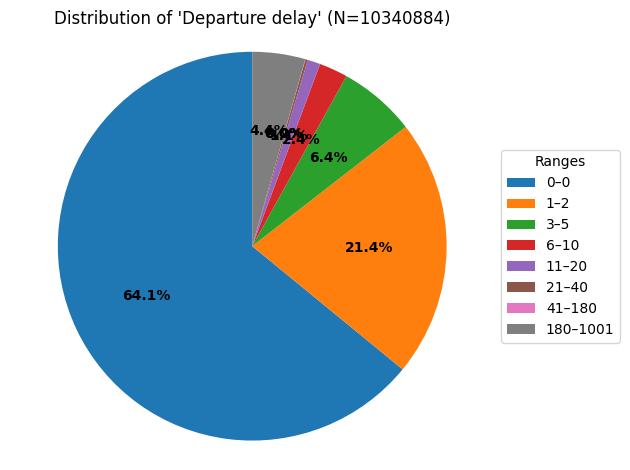

0–0 - 64.1%, 6626157
1–2 - 21.4%, 2216863
3–5 - 6.4%, 665341
6–10 - 2.4%, 245896
11–20 - 1.1%, 109435
21–40 - 0.2%, 20639
41–180 - 0.0%, 1738
180–1001 - 4.4%, 454811


['0–0 - 64.1%, 6626157',
 '1–2 - 21.4%, 2216863',
 '3–5 - 6.4%, 665341',
 '6–10 - 2.4%, 245896',
 '11–20 - 1.1%, 109435',
 '21–40 - 0.2%, 20639',
 '41–180 - 0.0%, 1738',
 '180–1001 - 4.4%, 454811']

In [ ]:
plot_range_pie(dataset_filtered, "Departure delay", test_ranges_1)

## Conclusion

Distance between train stations weekly correlates with the arrival delay.
One-hot encoding of station type correlates with the delay much better.
Especially when it comes to rare station types like facultatief station. This will allow the model to directly see potential correlations.

### Features that influence departure delay most (updated):
1. Departure platform changed
2. Arrival platform changed
3. Is holiday
4. Station types (facultatiefstation)
5. Is rush hour
6. Train type
7. Distance between stations
8. Is weekend

### We can potentially calculate this information from the station (but it will be extra effort)
- Amount of ALL trains that arrived and departed from a station (calculate the occurencies of a station in a raw dataset)

In [ ]:
main_dataset.to_csv('preprocessed_data/preprocessed_with_stations_metadata.csv', index=False)